In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv('tripadvisor_hotel_reviews.csv')

def assign_sentiment_by_rating(rating):
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Negative'

data['True_Sentiment'] = data['Rating'].apply(assign_sentiment_by_rating)

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['True_Sentiment'])

X_train, X_test, y_train, y_test = train_test_split(data['Review'], y, test_size=0.2, random_state=42)

import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(list(X_train), truncation=True, padding=True, return_tensors='tf')
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, return_tensors='tf')


In [6]:
train_labels = tf.convert_to_tensor(y_train)
test_labels = tf.convert_to_tensor(y_test)

In [7]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_encoder.classes_))

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [8]:
model.fit(train_encodings.data, train_labels, epochs=1, batch_size=16, validation_split=0.1)

922/922 [==============================] - 30871s 34s/step - loss: 0.3865 - accuracy: 0.8556 - val_loss: 0.2942 - val_accuracy: 0.8805


In [9]:
model.save_pretrained("saved_model/distilbert-sentiment")
tokenizer.save_pretrained("saved_model/distilbert-sentiment")

('saved_model/distilbert-sentiment/tokenizer_config.json',
 'saved_model/distilbert-sentiment/special_tokens_map.json',
 'saved_model/distilbert-sentiment/vocab.txt',
 'saved_model/distilbert-sentiment/added_tokens.json')

In [ ]:
preds = model.predict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask']
}).logits

y_pred = tf.argmax(preds, axis=1).numpy()

results_df = pd.DataFrame({
    'Review': X_test.values,
    'True Sentiment': label_encoder.inverse_transform(y_test),
    'Predicted Sentiment': label_encoder.inverse_transform(y_pred)
})

print("\n=== Sample Predictions (First 25) ===")
print(results_df.head(25))

129/129 [==============================] - 999s 8s/step

=== Sample Predictions (First 25) ===
                                               Review True Sentiment  \
0   not recommend hotel did reviewers actually sta...       Negative   
1   barcelona rocks, stayed hotel jazz girlfriend ...       Positive   
2   ok hotel good location stayed night way beijin...        Neutral   
3   great service nice pool ok beach lovely ground...       Positive   
4   surprising treat spent weekend july 15/16 2006...       Positive   
5   fantastic stay affinia 50 stayed affinia 50 de...       Positive   
6   great choice, stayed argonaut 7th 10th sepembe...       Positive   
7   treat good room glimpse bridge, thought room, ...       Positive   
8   par price stayed marco polo hotel 1 night nove...       Negative   
9   great value money tegal sari lovely hotel, wif...       Positive   
10  great hotel perfect central location just came...       Positive   
11  beautiful just returned 5 night stay 

=== Classification Report ===
              precision    recall  f1-score   support

    Negative       0.81      0.86      0.83       625
     Neutral       0.56      0.31      0.40       432
    Positive       0.93      0.97      0.95      3042

    accuracy                           0.89      4099
   macro avg       0.76      0.72      0.73      4099
weighted avg       0.87      0.89      0.87      4099



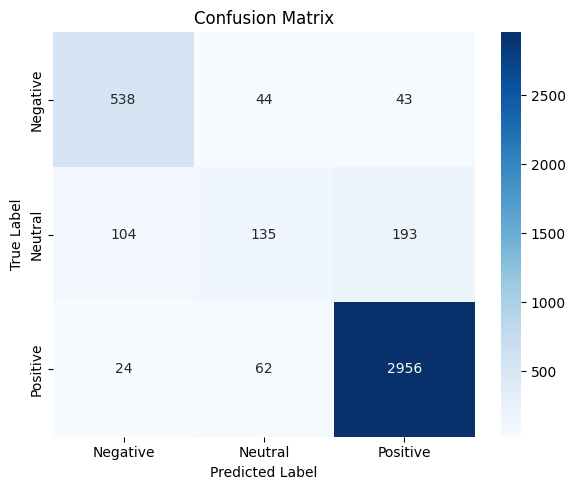

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()